In [1]:
import pandas as pd
from pathlib import Path
import torch
import sys
sys.path.append('src')

# from models.ae_kan import KANAutoencoder
from src.utils.new_preprocessing import preprocessing_dataset, simple_train_kan, change_hyperparam

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"Memory available: {torch.cuda.mem_get_info()[0] / 1024**3:.1f} GB")

print(f"Device : {device}")

GPU: NVIDIA GeForce RTX 3070 Laptop GPU
Total memory: 8.0 GB
Memory available: 6.9 GB
Device : cuda


In [2]:
data_dir = Path("data/processed/sectors")
sectors_list = [d.name for d in data_dir.iterdir() if d.is_dir() and d.name != 'unknown']

sector_log_returns = {}
for sector in sectors_list:
    returns_path = data_dir / sector / "log_returns.csv"
    df = pd.read_csv(returns_path, index_col=0)
    sector_log_returns[sector] = df.iloc[1:]  # Skip first row with NaN values

In [3]:
X_df = {}
W_df = {}
M_df = {}
data = {}

for sector in sector_log_returns:
    # Preprocess data for each sector
    X_df[sector], W_df[sector], M_df[sector] = preprocessing_dataset(
        log_returns_df=sector_log_returns[sector],
        win=60,
        min_periods=40,
        clip_val=3.0,
        min_valid_per_day=5,
        use_median=True,
        soft_weights=True
    )
    
    # Create tensors for each sector
    tensors = {
        'X': torch.tensor(X_df[sector].values, dtype=torch.float32),
        'W': torch.tensor(W_df[sector].values, dtype=torch.float32),
        'M': torch.tensor(M_df[sector].values, dtype=torch.float32)
    }

    # Split into train/test for each sector
    train_size = int(0.8 * len(tensors['X']))
    data[sector] = {
        'train': {
            'X': tensors['X'][:train_size],
            'W': tensors['W'][:train_size],
            'M': tensors['M'][:train_size]
        },
        'test': {
            'X': tensors['X'][train_size:],
            'W': tensors['W'][train_size:],
            'M': tensors['M'][train_size:]
        }
    }

print(f"\nSector: {sector}")
print(f"Train: {data[sector]['train']['X'].shape[0]} échantillons")
print(f"Test: {data[sector]['test']['X'].shape[0]} échantillons") 
print(f"Dates train: {X_df[sector].index[0]} à {X_df[sector].index[train_size-1]}")
print(f"Dates test: {X_df[sector].index[train_size]} à {X_df[sector].index[-1]}")


Sector: utilities
Train: 2987 échantillons
Test: 747 échantillons
Dates train: 2010-03-03 à 2022-01-10
Dates test: 2022-01-11 à 2024-12-31


In [4]:
log_returns_df = pd.read_csv("data/processed/dataset_log_returns.csv", index_col=0)
log_returns_df = log_returns_df.iloc[1:]

In [6]:
sp500_X_df, sp500_W_df, sp500_M_df = preprocessing_dataset(
    log_returns_df=log_returns_df,  # Utilise tous les returns
    win=60,
    min_periods=40, 
    clip_val=3.0,
    min_valid_per_day=5,
    use_median=True,
    soft_weights=True
)

sp500_tensors = {
    'X': torch.tensor(sp500_X_df.values, dtype=torch.float32),
    'W': torch.tensor(sp500_W_df.values, dtype=torch.float32), 
    'M': torch.tensor(sp500_M_df.values, dtype=torch.float32)
}

# Split train/test
train_size = int(0.8 * len(sp500_tensors['X']))
full_data = {
    'train': {
        'X': sp500_tensors['X'][:train_size],
        'W': sp500_tensors['W'][:train_size],
        'M': sp500_tensors['M'][:train_size]
    },
    'test': {
        'X': sp500_tensors['X'][train_size:],
        'W': sp500_tensors['W'][train_size:],
        'M': sp500_tensors['M'][train_size:]
    }
}

# MLP AE Training

In [11]:
from src.models.ae_mlp import MLPAutoencoder


input_dim = full_data['train']['X'].shape[1]
k = 10  # Nombre de facteurs latents
hidden_dims = (256, 128, 64)  # Architecture de l'encodeur

# Création du modèle
mlp_model = MLPAutoencoder(
    input_dim=input_dim,
    k=k,
    hidden=hidden_dims,
    activation='silu',
    use_bn=True,        # Batch normalization
    dropout_p=0.1,      # Dropout pour régularisation
    loss_type='huber',     # Mean Squared Error
).to(device)

# Affichage de l'architecture
print("\n🏗️ Architecture MLP Autoencoder:")
print(f"Input: {input_dim} → Encoder: {' → '.join(map(str, hidden_dims))} → Latent: {k}")
print(f"Latent: {k} → Decoder: {' → '.join(map(str, reversed(hidden_dims)))} → Output: {input_dim}")

# Nombre de paramètres
total_params = sum(p.numel() for p in mlp_model.parameters())
trainable_params = sum(p.numel() for p in mlp_model.parameters() if p.requires_grad)
print(f"📊 Paramètres totaux: {total_params:,}")
print(f"📊 Paramètres entraînables: {trainable_params:,}")


🏗️ Architecture MLP Autoencoder:
Input: 423 → Encoder: 256 → 128 → 64 → Latent: 10
Latent: 10 → Decoder: 64 → 128 → 256 → Output: 423
📊 Paramètres totaux: 302,769
📊 Paramètres entraînables: 302,769


In [12]:
from datetime import datetime

# Paramètres d'entraînement
training_config = {
    'epochs': 150,
    'batch_size': 128,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'validation_split': 0.2,
    'patience': 15,
    'verbose': True
}

print(f"⚙️ Configuration d'entraînement:")
for key, value in training_config.items():
    print(f"   {key}: {value}")

# Entraînement
start_time = datetime.now()
history = mlp_model.fit(
    X=full_data['train']['X'],
    **training_config,
    device=device
)
end_time = datetime.now()

print(f"\n✅ Entraînement terminé en {(end_time - start_time).total_seconds():.1f}s")
print(f"🎯 Meilleure loss de validation: {min(history.get('val_loss', [float('inf')])):.6f}")
print(f"📈 Loss finale d'entraînement: {history['train_loss'][-1]:.6f}")

⚙️ Configuration d'entraînement:
   epochs: 150
   batch_size: 128
   learning_rate: 0.001
   weight_decay: 1e-05
   validation_split: 0.2
   patience: 15
   verbose: True


c:\Users\xtrem\Documents\Git\DimRed-KAN-Finance\src\models\ae_mlp.py:188: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(amp and device.type == "cuda"))


🚀 ENTRAÎNEMENT MLP AUTOENCODER
📊 Data: 2390 train | 597 val
🏗️  Arch: 423 -> 256 -> 128 -> 64 -> 10 -> 64 -> 128 -> 256 -> 423
⚙️  Params: epochs=150, bs=128, lr=0.001, loss=huber
🔧 Device: cuda | AMP: True
🔢 Paramètres: 302,769 total | 302,769 entraînables
----------------------------------------------------------------------------------------


c:\Users\xtrem\Documents\Git\DimRed-KAN-Finance\src\models\ae_mlp.py:220: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(amp and device.type == "cuda")):


📈 Époque   1/150 | Train: 0.630550 | Val: 0.556167 ⚠️ | LR: 1.00e-03 | ⏱️ 5.2s (ETA: 768.8s)
📈 Époque   2/150 | Train: 0.546960 | Val: 0.521100 ⚠️ | LR: 1.00e-03 | ⏱️ 5.5s (ETA: 405.2s)
📈 Époque   3/150 | Train: 0.525842 | Val: 0.506419 ⚠️ | LR: 1.00e-03 | ⏱️ 5.7s (ETA: 280.9s)
📈 Époque   4/150 | Train: 0.511417 | Val: 0.493059 ⚠️ | LR: 1.00e-03 | ⏱️ 6.1s (ETA: 221.7s)
📈 Époque   5/150 | Train: 0.501103 | Val: 0.487359 ⚠️ | LR: 1.00e-03 | ⏱️ 6.4s (ETA: 185.8s)
📈 Époque   6/150 | Train: 0.494748 | Val: 0.484613 ⚠️ | LR: 1.00e-03 | ⏱️ 6.8s (ETA: 162.2s)
📈 Époque   7/150 | Train: 0.491428 | Val: 0.482608 ⚠️ | LR: 1.00e-03 | ⏱️ 7.1s (ETA: 145.2s)
📈 Époque   8/150 | Train: 0.489405 | Val: 0.480828 ⚠️ | LR: 1.00e-03 | ⏱️ 7.4s (ETA: 131.8s)
📈 Époque   9/150 | Train: 0.484293 | Val: 0.477033 ⚠️ | LR: 1.00e-03 | ⏱️ 7.7s (ETA: 121.1s)
📈 Époque  10/150 | Train: 0.480937 | Val: 0.472127 ⚠️ | LR: 1.00e-03 | ⏱️ 8.0s (ETA: 112.3s)
📈 Époque  11/150 | Train: 0.476078 | Val: 0.467990 ⚠️ | LR: 1.00e-03 |

In [18]:
# Évaluation sur les données de test
mlp_model.eval()
with torch.no_grad():
    X_test = full_data['test']['X'].to(device)
    
    # Extraction des facteurs latents
    latent_factors = mlp_model.encode(X_test)
    
    # Reconstruction - Utiliser la méthode reconstruct()
    X_reconstructed = mlp_model.reconstruct(X_test)
    
    # Calcul de l'erreur de reconstruction
    test_loss = torch.nn.functional.mse_loss(X_reconstructed, X_test).item()
    
    print(f"📊 Résultats sur le test set:")
    print(f"   Test Loss (MSE): {test_loss:.6f}")
    print(f"   Facteurs latents extraits: {latent_factors.shape}")
    
    # Conversion en numpy pour analyse
    latent_factors_np = latent_factors.cpu().numpy()
    X_test_np = X_test.cpu().numpy()
    X_recon_np = X_reconstructed.cpu().numpy()


latent_factors_np

📊 Résultats sur le test set:
   Test Loss (MSE): 0.471434
   Facteurs latents extraits: torch.Size([747, 10])


array([[ 0.06301846,  1.6323444 ,  0.16469994, ..., -0.00718171,
        -0.7254632 ,  0.24720708],
       [-0.2954598 ,  0.20041834,  0.15535465, ...,  0.05154741,
        -0.41020387, -0.23822749],
       [-0.22140305, -2.5531628 , -1.0050205 , ...,  0.04847025,
        -0.25339124, -1.1358911 ],
       ...,
       [-0.01696738, -0.18450212, -0.36065343, ..., -0.01118131,
         0.58962846,  0.21017762],
       [-0.47082907,  0.1588896 , -0.25789538, ..., -0.51135546,
        -0.13005517, -0.1096333 ],
       [ 0.51367134, -0.34206262,  0.20753276, ..., -0.450657  ,
         0.1249038 , -0.03257283]], dtype=float32)

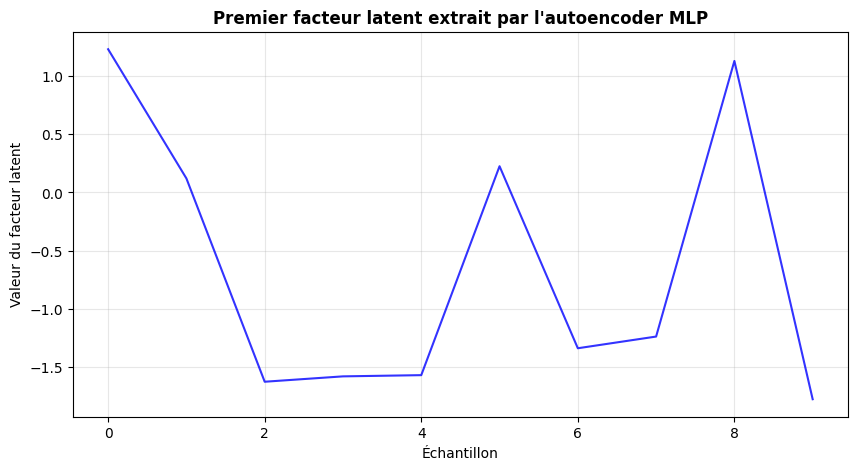

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(latent_factors_np[3], color='blue', alpha=0.8)
plt.xlabel('Échantillon')
plt.ylabel('Valeur du facteur latent')
plt.title('Premier facteur latent extrait par l\'autoencoder MLP', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# Comparaison entrée/sortie pour un exemple
import pandas as pd

# Sélection d'un exemple aléatoire
sample_idx = 42  # On peut changer cet indice

# Création d'un DataFrame avec les valeurs originales et reconstruites
comparison_df = pd.DataFrame({
    'Original': X_test_np[sample_idx],
    'Reconstruction': X_recon_np[sample_idx],
    'Erreur quadratique': (X_test_np[sample_idx] - X_recon_np[sample_idx])**2
})

# Affichage du DataFrame avec formatage
pd.set_option('display.float_format', lambda x: '%.6f' % x)
display(comparison_df)

# Affichage de l'erreur de reconstruction moyenne
mse = ((X_test_np[sample_idx] - X_recon_np[sample_idx])**2).mean()
print(f"\nErreur de reconstruction moyenne (MSE) pour l'exemple {sample_idx}: {mse:.6f}")

,Original,Reconstruction,Erreur quadratique
0,-0.845588,0.163924,1.019114
1,-1.214788,-0.682034,0.283826
2,1.094769,0.468030,0.392802
3,0.927039,0.633999,0.085873
4,-0.352534,0.336345,0.474553
...,...,...,...
418,-0.400132,0.037363,0.191402
419,-1.987534,-0.553962,2.055130
420,-1.416983,-0.214371,1.446276
421,-0.378731,-0.052502,0.106426



Erreur de reconstruction moyenne (MSE) pour l'exemple 42: 0.651287
